In [1]:
library(tidyverse)
library(gridExtra)
library(scales)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



In [2]:
`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

In [3]:
ppi_df <- read_tsv('../../data/4.data/ppi.tsv.xz')

head(ppi_df, 2)

Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  network = col_character(),
  edge = col_double(),
  edge_prior = col_double(),
  rwr = col_double(),
  mean_rwr = col_double(),
  p_rwr = col_double(),
  jaccard = col_double(),
  mean_jaccard = col_double(),
  p_jaccard = col_double()
)


id_a,id_b,network,edge,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
0,0,train,0,0,2.516038e-01,0.2512483655,0.038,1,1.000000000,1
0,1,train,0,0,1.582702e-05,0.0000145586,0.088,0,0.001491855,1


In [4]:
nodes_df <- read_tsv('../../data/3.all_nodes/ppi.tsv.xz')

node_degree <- nodes_df %>%
    select(id_a, id_b, train) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train), funs(sum)) %>%
    rename(degree=train)

head(node_degree, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session.”

id,degree
0,55
1,3


In [5]:
degree_df <- ppi_df %>%
    sample_n(10000) %>%
    filter(id_a != id_b) %>%
    left_join(node_degree, by = c('id_a' = 'id')) %>%
    left_join(node_degree, by = c('id_b' = 'id'), suffix = c('_a', '_b')) %>%
    mutate(
        degree_geo_mean=sqrt(degree_a * degree_b),
        degree_ari_mean=(degree_a + degree_b) / 2
    ) %>%
    gather('degree_side', 'degree', degree_a, degree_b, degree_geo_mean, degree_ari_mean) %>%
    mutate(
        degree_side = (
            str_extract(degree_side, 'ari_mean|geo_mean|a|b') %>% 
            recode(a = 'source degree', b = 'target degree', 
                   geo_mean = 'geometric mean degree',
                   ari_mean = 'arithmetic mean degree')
        )
    ) %>%
    gather('feature_name', 'feature_value', jaccard, p_jaccard, rwr, p_rwr) %>%
    mutate(
        feature_type = (
            feature_name %>% 
            recode(jaccard = 'feature', p_jaccard = 'corrected feature',
                   rwr = 'feature', p_rwr = 'corrected feature') %>%
            factor(levels=c('feature', 'corrected feature'))
        ),
        feature_name = (
            feature_name %>% 
            recode(p_jaccard = 'jaccard', p_rwr = 'rwr')
        )
    )

head(degree_df, 2)

id_a,id_b,network,edge,edge_prior,mean_rwr,mean_jaccard,degree_side,degree,feature_name,feature_value,feature_type
1971,3017,test_recon,0,0.052,0.0002053096,0.04471470,source degree,89,jaccard,0.02708804,feature
1442,3718,test_recon,0,0.062,0.0002125379,0.04742905,source degree,150,jaccard,0.04336735,feature


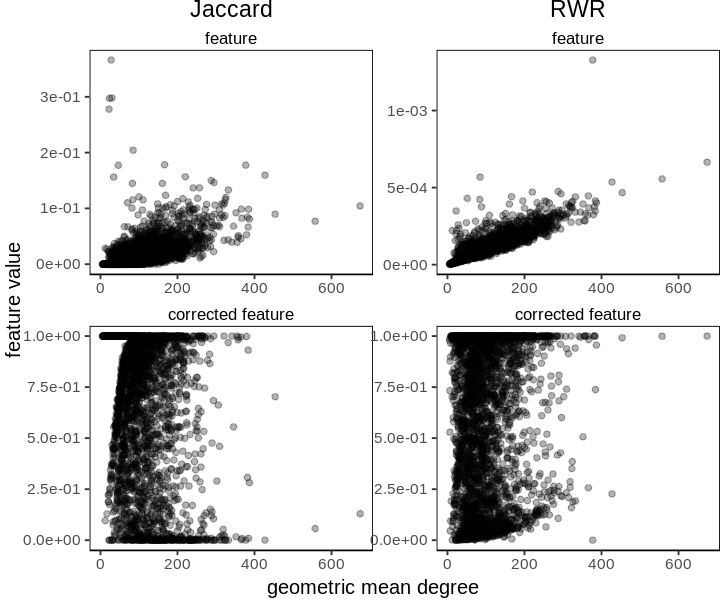

In [12]:
options(repr.plot.width=6, repr.plot.height=5)

jaccard <- (
    ggplot(
        degree_df %>% 
            filter(feature_name == 'jaccard' & degree_side == 'geometric mean degree' 
                   & network == 'train' & edge == 0), 
        aes(x = degree, y = feature_value))
    + geom_point(alpha=0.3)
    + facet_wrap(vars(feature_type), scales='free', ncol = 1)
    
    + ggtitle('Jaccard')
    + xlab(NULL)
    + ylab(NULL)
    + scale_y_continuous(labels=scientific)
    + theme_zietzm()
    + theme(plot.title = element_text(hjust = 0.5), plot.margin = unit(0 * c(1,1,1,1), "cm"))
)

rwr <- (
    ggplot(
        degree_df %>% 
            filter(feature_name == 'rwr' & degree_side == 'geometric mean degree' 
                  & network == 'train' & edge == 0), 
        aes(x = degree, y = feature_value)
    )
    + geom_point(alpha=0.3)
    + facet_wrap(vars(feature_type), scales='free', ncol = 1)
    + ggtitle('RWR')
    + xlab(NULL)
    + ylab(NULL)
    + scale_y_continuous(labels=scientific)
    + theme_zietzm()
    + theme(plot.title = element_text(hjust = 0.5), plot.margin = unit(0 * c(1,1,1,1), "cm"))
)

arranged <- (
    grid.arrange(jaccard, rwr, ncol = 2, bottom = "geometric mean degree", left = 'feature value',
                padding = unit(0.5, "line"))
)
ggsave(filename = '../../img/5_corrected_features_not_correlated/points.png', plot = arranged, 
       dpi = 500, height = 5, width = 6)

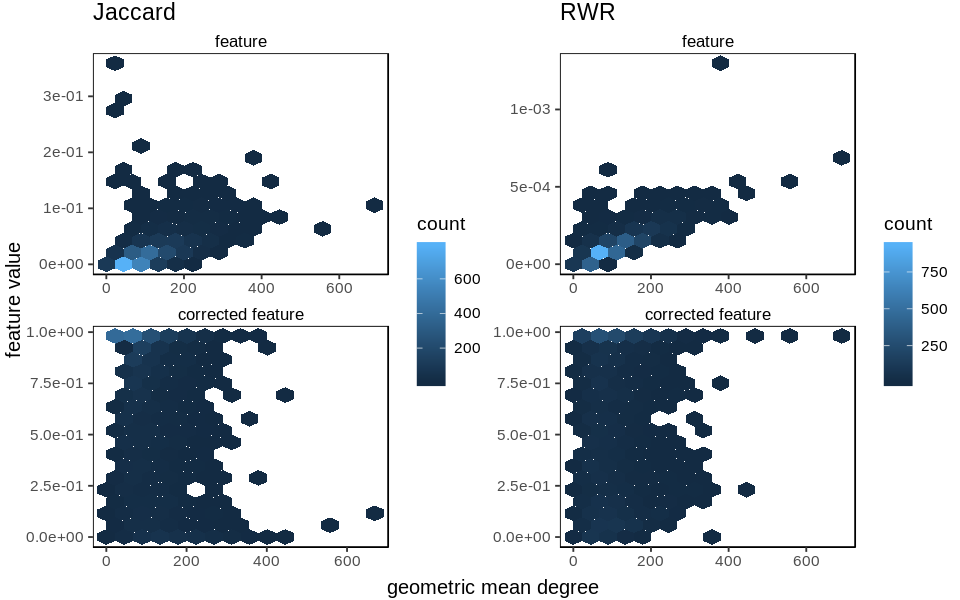

In [7]:
options(repr.plot.width=8, repr.plot.height=5)

jaccard <- (
    ggplot(
        degree_df %>% 
            filter(feature_name == 'jaccard' & degree_side == 'geometric mean degree' 
                   & network == 'train' & edge == 0), 
        aes(x = degree, y = feature_value))
    + geom_hex(bins = 15)
    + facet_wrap(vars(feature_type), scales='free', ncol = 1)
    
    + ggtitle('Jaccard')
    + theme(plot.title = element_text(hjust = 0.5), plot.margin = unit(0 * c(1,1,1,1), "cm"))
    + xlab(NULL)
    + ylab(NULL)
    + scale_y_continuous(labels=scientific)
    + theme_zietzm()
)

rwr <- (
    ggplot(
        degree_df %>% 
            filter(feature_name == 'rwr' & degree_side == 'geometric mean degree' 
                  & network == 'train' & edge == 0), 
        aes(x = degree, y = feature_value)
    )
    + geom_hex(bins = 15)
    + facet_wrap(vars(feature_type), scales='free', ncol = 1)
    
    + ggtitle('RWR')
    + theme(plot.title = element_text(hjust = 0.5), plot.margin = unit(0 * c(1,1,1,1), "cm"))
    + xlab(NULL)
    + ylab(NULL)
    + scale_y_continuous(labels=scientific)
    + theme_zietzm()
)

arranged <- (
    grid.arrange(jaccard, rwr, ncol = 2, bottom = "geometric mean degree", left = 'feature value',
                padding = unit(0.5, "line"))
)
ggsave(filename = '../../img/5_corrected_features_not_correlated/hex.png', plot = arranged, 
       dpi = 500, height = 5, width = 8)

Warning message:
“Removed 3309 rows containing missing values (geom_point).”

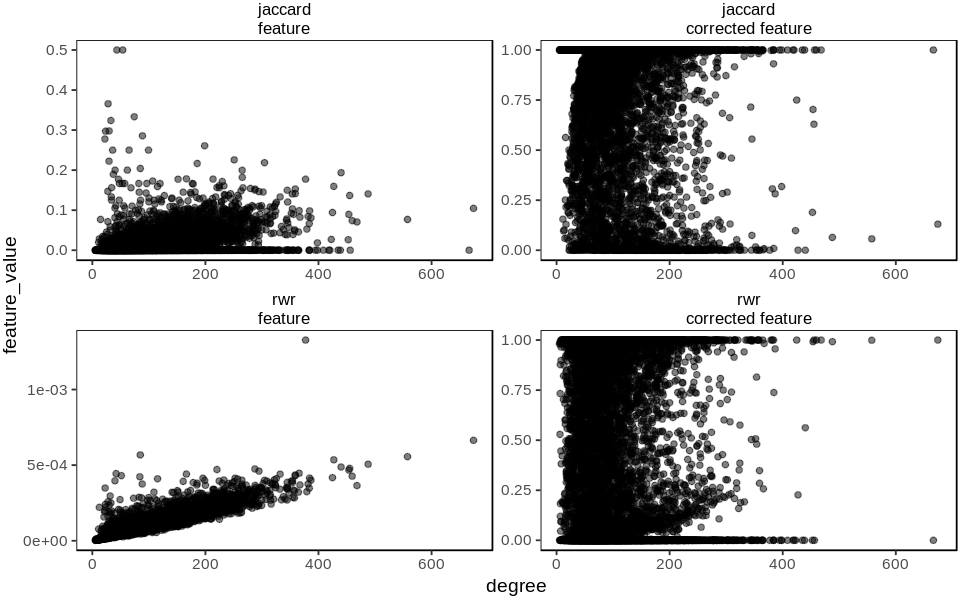

In [8]:
(
    ggplot(degree_df %>% filter(degree_side == 'geometric mean degree' & edge == 0 & id_a != id_b), 
           aes(x = degree, y = feature_value))
    + geom_point(alpha=0.5)
    + facet_wrap(vars(feature_name, feature_type), scales='free')
    + theme_zietzm()
)